In [2]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
import glob
import random
import midi

from importlib import reload

reload(midi)  # To reflect the changes.

random.seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
midi_file_paths = glob.glob("./datasets/jazzomat/*.mid")
print("Num of tacks: ", len(midi_file_paths))

SEQUENCE_LEN = 4
midi_files = []
# TODO: rm the limit.
for f_name in midi_file_paths:
    if (
        midi_file := midi.MidiFile.from_filepath(f_name, sequence_len=SEQUENCE_LEN)
    ) != None and midi_file.has_instrument("piano"):
        midi_files.append(midi_file)

random.shuffle(midi_files)

Num of tacks:  456


In [5]:
midi_files_train = midi_files[: int(0.8 * len(midi_files))]
midi_files_test = midi_files[len(midi_files_train) :]

print("Num of train tracks: ", len(midi_files_train))
print("Num of test tracks: ", len(midi_files_test))

Num of train tracks:  364
Num of test tracks:  92


In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        if hidden is None:
            batch_size = x.size(0)
            hidden = self._init_hidden(batch_size)
        else:
            hidden = hidden.clone().detach()

        out, hidden = self.rnn(x, hidden)

        output = self.fc(out)

        return output, hidden

    def _init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size)

In [7]:
NUM_OF_FEATURES = 4  # pitches + velocity + step + duration
NUM_CLASSES = 128  # a number of possible values for pitches/velocities
FEATURE_SIZE = 128 + 128 + 1 + 1  # pitches + velocity + step + duration

hparams = {
    "batch_size": 64,
    "num_classes": NUM_CLASSES,
    "hidden_size": 2 * 512,
    "num_epochs": 100,
    "learning_rate": 0.0001,
    "num_layers": 2,
    "num_epochs": 1,
    # "num_workers": 4,
}

model = RNN(
    input_size=FEATURE_SIZE,
    hidden_size=hparams["hidden_size"],
    output_size=FEATURE_SIZE,
    n_layers=hparams["num_layers"],
)

optim = torch.optim.Adam(model.parameters(), lr=hparams["learning_rate"])
# optim = torch.optim.SGD(model.parameters(), lr=0.0001)

class_loss = nn.CrossEntropyLoss()
reg_loss = nn.MSELoss()


def prepare_input(input_batch: torch.Tensor) -> torch.Tensor:
    pitch_one_hot = F.one_hot(input_batch[:, :, 0].long(), num_classes=NUM_CLASSES)
    velocity_one_hot = F.one_hot(input_batch[:, :, 1].long(), num_classes=NUM_CLASSES)

    input = torch.cat(
        (pitch_one_hot.float(), velocity_one_hot.float(), input_batch[:, :, 2:]), dim=2
    )

    # Add zero padding if necessary.
    if input.shape[0] != hparams["batch_size"]:
        input = torch.cat(
            (
                input,
                torch.zeros(
                    (hparams["batch_size"] - input.shape[0]), SEQUENCE_LEN, FEATURE_SIZE
                ),
            ),
            dim=0,
        )

    assert input.shape == (
        hparams["batch_size"],
        SEQUENCE_LEN,
        FEATURE_SIZE,
    ), f"Actual: {input.shape}"

    return input


def prepare_target(target_batch: torch.Tensor) -> torch.Tensor:
    if target_batch.shape[0] != hparams["batch_size"]:
        target_batch = torch.cat(
            (
                target_batch,
                torch.zeros(
                    (hparams["batch_size"] - target_batch.shape[0]),
                    SEQUENCE_LEN,
                    NUM_OF_FEATURES,
                ),
            ),
            dim=0,
        )

    assert target_batch.shape == (
        hparams["batch_size"],
        SEQUENCE_LEN,
        NUM_OF_FEATURES,
    ), f"Actual: {target_batch.shape}"

    return target_batch


def total_loss(
    output: torch.Tensor, target_batch: torch.Tensor
) -> tuple[torch.Tensor, dict]:
    pitch_in, pitch_target = (
        output[:, :, :NUM_CLASSES],
        target_batch[:, :, 0].long(),
    )
    vel_in, vel_target = (
        output[:, :, NUM_CLASSES : 2 * NUM_CLASSES],
        target_batch[:, :, 1].long(),
    )

    assert pitch_in.view(-1, pitch_in.shape[-1]).shape == (
        hparams["batch_size"] * SEQUENCE_LEN,
        NUM_CLASSES,
    )
    assert (
        output[:, :, 2 * NUM_CLASSES].shape
        == target_batch[:, :, 2].shape
        == (hparams["batch_size"], SEQUENCE_LEN)
    ), f"Actual (input, target): {output[:, :, 2 * NUM_CLASSES].shape}, {target_batch[:, :, 2].shape}"

    losses = {
        "pitches": class_loss(
            pitch_in.view(-1, pitch_in.shape[-1]), pitch_target.view(-1)
        ),
        "velocity": class_loss(vel_in.view(-1, vel_in.shape[-1]), vel_target.view(-1)),
        "step": reg_loss(output[:, :, 2 * NUM_CLASSES], target_batch[:, :, 2]),
        "duration": reg_loss(output[:, :, 2 * NUM_CLASSES + 1], target_batch[:, :, 3]),
    }

    total_loss = 0.25 * (
        losses["pitches"] + losses["velocity"] + losses["step"] + losses["duration"]
    )

    for k, v in losses.items():
        losses[k] = v.item()

    return total_loss, losses


# torch.autograd.set_detect_anomaly(True)
hs = None
losses = []
i = 0

for epoch in range(hparams["num_epochs"]):
    random.shuffle(midi_files_train)

    for midi_file in midi_files_train:
        for input_batch, target_batch in DataLoader(
            midi_file, batch_size=hparams["batch_size"]
        ):
            input = prepare_input(input_batch)
            target = prepare_target(target_batch)

            optim.zero_grad()

            output, hs = model(input, hs)

            loss, loss_dict = total_loss(output, target)
            losses.append(loss.item())
            loss.backward()

            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optim.step()

            if i % 500 == 0:  # print every once in a while
                print(
                    f"Epoch [{epoch + 1}/{hparams['num_epochs']}, ",
                    f"Iter: {i:7d}, ",
                    f"Total Loss: {loss.item():.4f}, Losses: {loss_dict}",
                )

            i += 1

Epoch [1/1,  Iter:       0,  Total Loss: 2.4619, Losses: {'pitches': 4.856762886047363, 'velocity': 4.850769519805908, 'step': 0.08792897313833237, 'duration': 0.05226295813918114}
Epoch [1/1,  Iter:     500,  Total Loss: 1.7666, Losses: {'pitches': 3.62978196144104, 'velocity': 3.42641019821167, 'step': 0.00974347721785307, 'duration': 0.0005914248758926988}
Epoch [1/1,  Iter:    1000,  Total Loss: 0.8455, Losses: {'pitches': 1.7403008937835693, 'velocity': 1.5700069665908813, 'step': 0.03234992176294327, 'duration': 0.039169978350400925}
Epoch [1/1,  Iter:    1500,  Total Loss: 1.5538, Losses: {'pitches': 2.7211341857910156, 'velocity': 3.4461512565612793, 'step': 0.04502999037504196, 'duration': 0.003023024881258607}
Epoch [1/1,  Iter:    2000,  Total Loss: 1.6875, Losses: {'pitches': 3.529808282852173, 'velocity': 3.18487548828125, 'step': 0.03308388963341713, 'duration': 0.0022868355736136436}
Epoch [1/1,  Iter:    2500,  Total Loss: 1.5132, Losses: {'pitches': 2.3702569007873535,

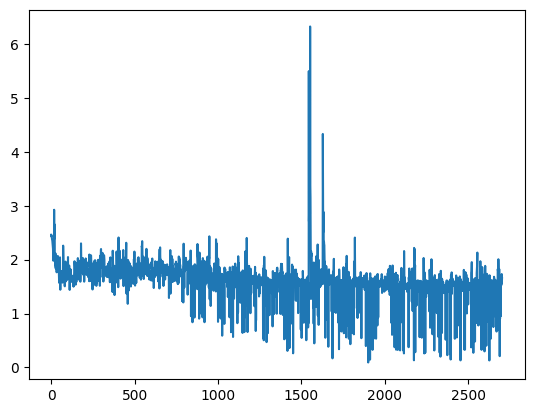

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(len(losses)), losses)

In [11]:
# midi_files = [midi_file]

# FEATURE_SIZE = 128 + 128 + 1 + 1  # pitches + velocity + step + duration
# HIDDEN_SIZE = 16

# eps = 0.01
# Wxh = torch.randn((FEATURE_SIZE, HIDDEN_SIZE)) * eps  # x @ Wx => (1, HIDDEN_SIZE)
# Whh = torch.randn((HIDDEN_SIZE, HIDDEN_SIZE)) * eps
# bh = torch.randn((1, HIDDEN_SIZE)) * eps

# Why = torch.randn((HIDDEN_SIZE, FEATURE_SIZE)) * eps
# by = torch.randn((1, FEATURE_SIZE)) * eps

# parameters = [Wxh, Whh, bh, Why, by]
# print("Num of parameters: ", sum(p.nelement() for p in parameters))

# for p in parameters:
#     p.requires_grad = True

# optim = torch.optim.SGD(parameters, lr=0.01)

# torch.autograd.set_detect_anomaly(True)


# def loss_fn(input, target, hs_prev):
#     hs, ys = {}, {}
#     hs[-1] = torch.clone(hs_prev)

#     losses = {
#         "pitches": torch.tensor(0.0),
#         "velocity": torch.tensor(0.0),
#         "step": torch.tensor(0.0),
#         "duration": torch.tensor(0.0),
#     }

#     NUM_CLASSES = 128

#     pitch_one_hot = F.one_hot(input[:, 0].long(), num_classes=NUM_CLASSES)
#     velocity_one_hot = F.one_hot(input[:, 1].long(), num_classes=NUM_CLASSES)
#     input = torch.cat(
#         (pitch_one_hot.float(), velocity_one_hot.float(), input[:, 2:]), dim=1
#     )

#     assert len(input[0]) == FEATURE_SIZE

#     print(hs[-1])
#     for i, x in enumerate(input):
#         print(hs[i - 1])
#         hs[i] = torch.tanh((x @ Wxh) + (hs[i - 1] @ Whh + bh))
#         ys[i] = hs[i] @ Why + by
#         # hs[i] = torch.tanh((x @ Wxh) + bh)
#         # ys[i] = hs[i] @ Why + by

#         y = ys[i].squeeze(0)
#         losses["pitches"] += F.cross_entropy(y[:NUM_CLASSES], target[i][0].long())
#         losses["velocity"] += F.cross_entropy(
#             y[NUM_CLASSES : 2 * NUM_CLASSES], target[i][1].long()
#         )
#         losses["step"] += F.mse_loss(y[2 * NUM_CLASSES], target[i][2])
#         losses["duration"] += F.mse_loss(y[2 * NUM_CLASSES + 1], target[i][3])

#         # TODO: rm
#         total_weighted_loss = 0.25 * (
#             losses["pitches"] + losses["velocity"] + losses["step"] + losses["duration"]
#         )
#         return hs[0], total_weighted_loss, ys

#     total_weighted_loss = 0.25 * (
#         losses["pitches"] + losses["velocity"] + losses["step"] + losses["duration"]
#     )

#     return hs[len(input) - 1], total_weighted_loss, ys


# hs = torch.rand((1, HIDDEN_SIZE)) * eps  # Initial hidden state.

# losses = []
# # Training loop.
# i = 0
# for midi_file in midi_files:
#     for input, pitch_target in midi_file:
#         hs, loss, ys = loss_fn(input, pitch_target, hs)

#         losses.append(loss.item())

#         loss.backward(retain_graph=True)

#         optim.step()
#         optim.zero_grad()

#         if i % 10000 == 0:  # print every once in a while
#             print(f"Iter: {i:7d}; Loss: {loss.item():.4f}")

#         i += 1

Num of parameters:  8786
tensor([[0.0047, 0.0027, 0.0083, 0.0055, 0.0010, 0.0035, 0.0038, 0.0002, 0.0044,
         0.0078, 0.0033, 0.0093, 0.0040, 0.0095, 0.0034, 0.0074]])
tensor([[0.0047, 0.0027, 0.0083, 0.0055, 0.0010, 0.0035, 0.0038, 0.0002, 0.0044,
         0.0078, 0.0033, 0.0093, 0.0040, 0.0095, 0.0034, 0.0074]])
Iter:       0; Loss: 2.5474
tensor([[-3.7824e-03, -2.8796e-03,  4.5614e-04,  1.0496e-02,  2.0337e-02,
          1.9680e-02, -8.1662e-03, -8.9442e-05, -1.3910e-02,  1.4040e-02,
         -2.1659e-02,  8.2750e-03,  2.8433e-02, -2.2356e-02,  1.2843e-02,
          1.4467e-02]], grad_fn=<CloneBackward0>)
tensor([[-3.7824e-03, -2.8796e-03,  4.5614e-04,  1.0496e-02,  2.0337e-02,
          1.9680e-02, -8.1662e-03, -8.9442e-05, -1.3910e-02,  1.4040e-02,
         -2.1659e-02,  8.2750e-03,  2.8433e-02, -2.2356e-02,  1.2843e-02,
          1.4467e-02]], grad_fn=<CloneBackward0>)
tensor([[-0.0080,  0.0072,  0.0019, -0.0205, -0.0014, -0.0167, -0.0169,  0.0046,
          0.0069,  0.0250,

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [16, 16]] is at version 2; expected version 1 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!